<a href="https://colab.research.google.com/github/aavila4/BME450-EKGanalysis/blob/main/BME450_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Path to dataset files: /kaggle/input/ecg-image-data
Files/Folders in dataset path: ['ECG_Image_data']
Using device: cpu
Classes: ['F', 'M', 'N', 'Q', 'S', 'V']
Train subset size: 9919, Test subset size: 2479
Epoch [1/5] Train Loss: 0.0898 Test Loss: 0.0052 Test Accuracy: 99.92%
Epoch [2/5] Train Loss: 0.0001 Test Loss: 0.0045 Test Accuracy: 99.92%
Epoch [3/5] Train Loss: 0.0000 Test Loss: 0.0052 Test Accuracy: 99.92%
Epoch [4/5] Train Loss: 0.0000 Test Loss: 0.0036 Test Accuracy: 99.92%
Epoch [5/5] Train Loss: 0.0000 Test Loss: 0.0047 Test Accuracy: 99.92%


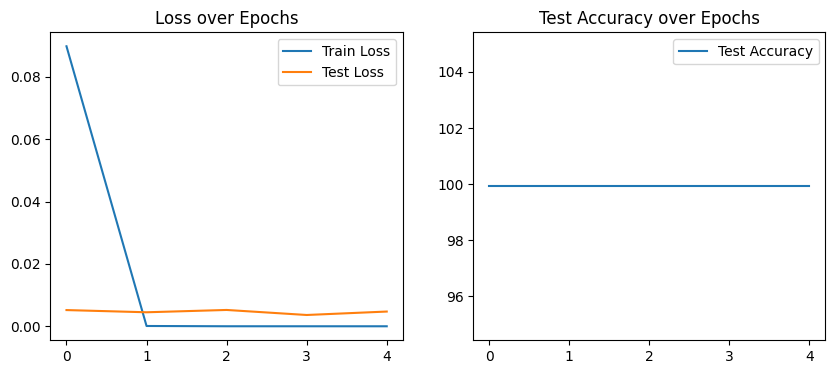

Model saved to ecg_cnn_model.pth


In [ ]:
import kagglehub
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Load Dataset via kagglehub
path = kagglehub.dataset_download("erhmrai/ecg-image-data")
print("Path to dataset files:", path)

print("Dataset Path:", path)
print("Files/Folders in dataset path:")
print(os.listdir(path))

data_root = os.path.join(path, "ECG_Image_data")
train_dir = os.path.join(data_root, "train")
test_dir = os.path.join(data_root, "test")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
BATCH_SIZE = 16
IMG_SIZE = (128, 128)
EPOCHS = 20
LEARNING_RATE = 0.001

transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("Classes:", train_dataset.classes)
print(f"Train size: {len(train_dataset)}, Test size: {len(test_dataset)}")


# Show Sample Images
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

images, labels = next(iter(train_loader))
imshow(torchvision.utils.make_grid(images[:8]))
print("Labels:", labels.numpy())

# CNN Model Definition
class ImprovedCNN(nn.Module):
    def __init__(self, num_classes):
        super(ImprovedCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 16 * 16, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize Model, Loss, Optimizer
num_classes = len(train_dataset.classes)
model = ImprovedCNN(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Training Loop
train_losses, test_losses, test_accuracies = [], [], []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    scheduler.step()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Evaluate
    model.eval()
    correct = 0
    total = 0
    test_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total
    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(test_accuracy)

    print(f"Epoch [{epoch+1}/{EPOCHS}] "
          f"Train Loss: {train_loss:.4f} "
          f"Test Loss: {test_losses[-1]:.4f} "
          f"Test Accuracy: {test_accuracy:.2f}%")

# Plot Loss and Accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.title("Loss over Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label="Test Accuracy")
plt.title("Test Accuracy over Epochs")
plt.legend()
plt.show()


# Save the Trained Model
torch.save(model.state_dict(), "ecg_cnn_model.pth")
print("Model saved to ecg_cnn_model.pth")


In [1]:
#Faster and optimized code

import kagglehub
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np
import random

# -----------------------------
# Load Dataset via kagglehub
# -----------------------------
path = kagglehub.dataset_download("erhmrai/ecg-image-data")
print("Path to dataset files:", path)
print("Files/Folders in dataset path:", os.listdir(path))

# Navigate to correct folders
data_root = os.path.join(path, "ECG_Image_data")
train_dir = os.path.join(data_root, "train")
test_dir = os.path.join(data_root, "test")

# -----------------------------
# Device & Config
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

BATCH_SIZE = 64       # Bigger batch size
IMG_SIZE = (64, 64)   # Smaller images
EPOCHS = 10           # Reasonable number of epochs
LEARNING_RATE = 0.001
SUBSET_FRACTION = 0.01  # ⬅ Use 1% of the data

# -----------------------------
# Image Transforms & Dataloaders
# -----------------------------
transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load full datasets
full_train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
full_test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

# -----------------------------
# Subset the datasets to make them smaller
# -----------------------------
def get_subset(dataset, fraction):
    size = int(len(dataset) * fraction)
    indices = random.sample(range(len(dataset)), size)
    return Subset(dataset, indices)

train_dataset = get_subset(full_train_dataset, SUBSET_FRACTION)
test_dataset = get_subset(full_test_dataset, SUBSET_FRACTION)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print("Classes:", full_train_dataset.classes)
print(f"Train subset size: {len(train_dataset)}, Test subset size: {len(test_dataset)}")

# -----------------------------
# CNN Model Definition
# -----------------------------
class ImprovedCNN(nn.Module):
    def __init__(self, num_classes):
        super(ImprovedCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 8 * 8, 256)  # Adjusted for 64x64 input
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# -----------------------------
# Initialize Model, Loss, Optimizer
# -----------------------------
num_classes = len(full_train_dataset.classes)
model = ImprovedCNN(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# -----------------------------
# Training Loop
# -----------------------------
train_losses, test_losses, test_accuracies = [], [], []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    scheduler.step()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Evaluation
    model.eval()
    correct = 0
    total = 0
    test_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total
    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(test_accuracy)

    print(f"Epoch [{epoch+1}/{EPOCHS}] "
          f"Train Loss: {train_loss:.4f} "
          f"Test Loss: {test_losses[-1]:.4f} "
          f"Test Accuracy: {test_accuracy:.2f}%")

# -----------------------------
# Plot Loss and Accuracy
# -----------------------------
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.title("Loss over Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label="Test Accuracy")
plt.title("Test Accuracy over Epochs")
plt.legend()
plt.show()

# -----------------------------
# Save the Trained Model
# -----------------------------
torch.save(model.state_dict(), "ecg_cnn_model.pth")
print("Model saved to ecg_cnn_model.pth")


Path to dataset files: /kaggle/input/ecg-image-data
Files/Folders in dataset path: ['ECG_Image_data']
Classes: ['F', 'M', 'N', 'Q', 'S', 'V']
Train subset size: 9919, Test subset size: 2479


NameError: name 'device' is not defined